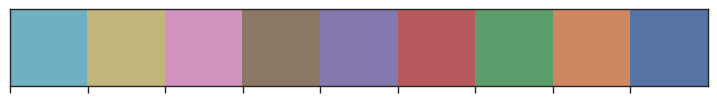

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as sc
import numba
from scipy import signal


sns.set()
sns.set_context("paper", font_scale=1.4)
sns.set_style("ticks")

colors = sns.color_palette('deep', 10, desat = 0.8)
colors = colors[::-1]
colors.pop(2)

sns.set_palette(colors)

sns.palplot(colors)
plt.rcParams['axes.grid'] = True
plt.rcParams['axes.grid.axis'] = 'y'
plt.rcParams['axes.grid.which'] = 'major'
plt.rcParams['grid.linestyle'] = '--'
plt.rcParams['grid.linewidth'] = 1.5
plt.rcParams['figure.figsize'] = (16, 9)
plt.rcParams['figure.dpi'] = 100

In [23]:
a = 2
b = 5.2
c = 1
d = 1

@numba.njit
def x_dot(x, y, V):
    dxdt = a*V - (b + d) * x + c/(V**2) * x**2 * y
    return dxdt

@numba.njit
def y_dot(x, y, V):
    dydt = b*x - c/(V**2) * x**2 * y
    return dydt
    
@numba.njit
def x_mark(V, a, d):
    return a*V / d

@numba.njit
def y_mark(V, a, b,  c, d):
    return V * b * d / (c * a)


In [24]:
# Euler method

@numba.njit
def euler(var_change, V, dt, t_max):
    var = var_change*V
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot(x, y, V)
        y += dt * y_dot(x, y, V)
        t += dt
    return x_list, y_list, t_list


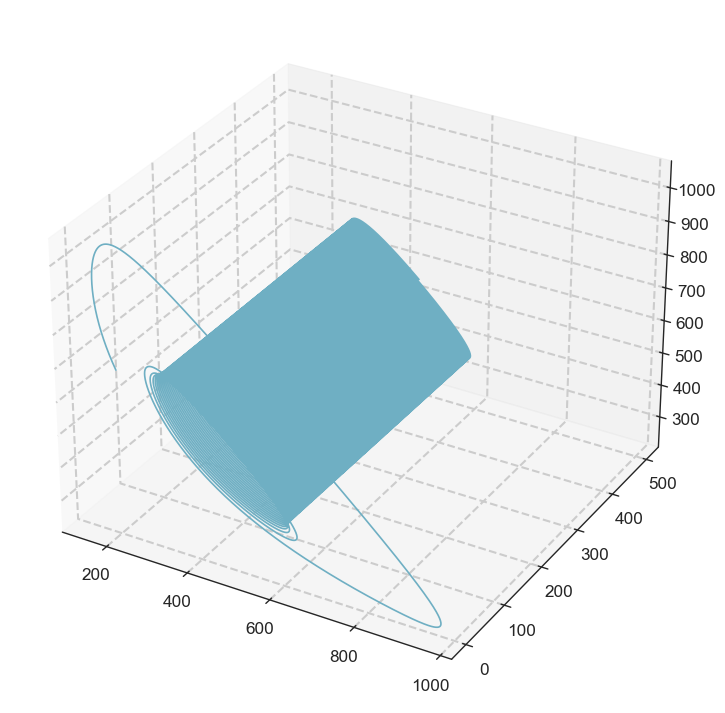

In [25]:

V = 200
var_change = np.array([1, 3.5])
dt = 0.001
t_max = 500

x_list, y_list, t_list = euler(var_change, V, dt, t_max)
x_star = x_mark(V, a, d)
y_star = y_mark(V, a, b, c, d)

# 3D plot
fig = plt.figure(figsize=(16,9), dpi=100)
ax = fig.add_subplot(111, projection='3d')
ax.plot(x_list, t_list, y_list)


In [26]:
# Finding peaks and mean freq of x(t) and y(t)

def freq_find(list1, list2):
    coord_peaks = []
    t_peaks = []
    for i in range(1, len(list1)-1):
        if list1[i] > list1[i-1] and list1[i] > list1[i+1]:
            coord_peaks.append(list1[i])
            t_peaks.append(list2[i])

    freq = []
    for j in range(len(t_peaks)-1):
        freq.append(1/(t_peaks[j+1] - t_peaks[j]))
    
    freq_mean = np.mean(freq)
    
    return freq_mean

# find the frequency of the peaks

x_mean_freq = freq_find(x_list, t_list)
y_mean_freq = freq_find(y_list, t_list)



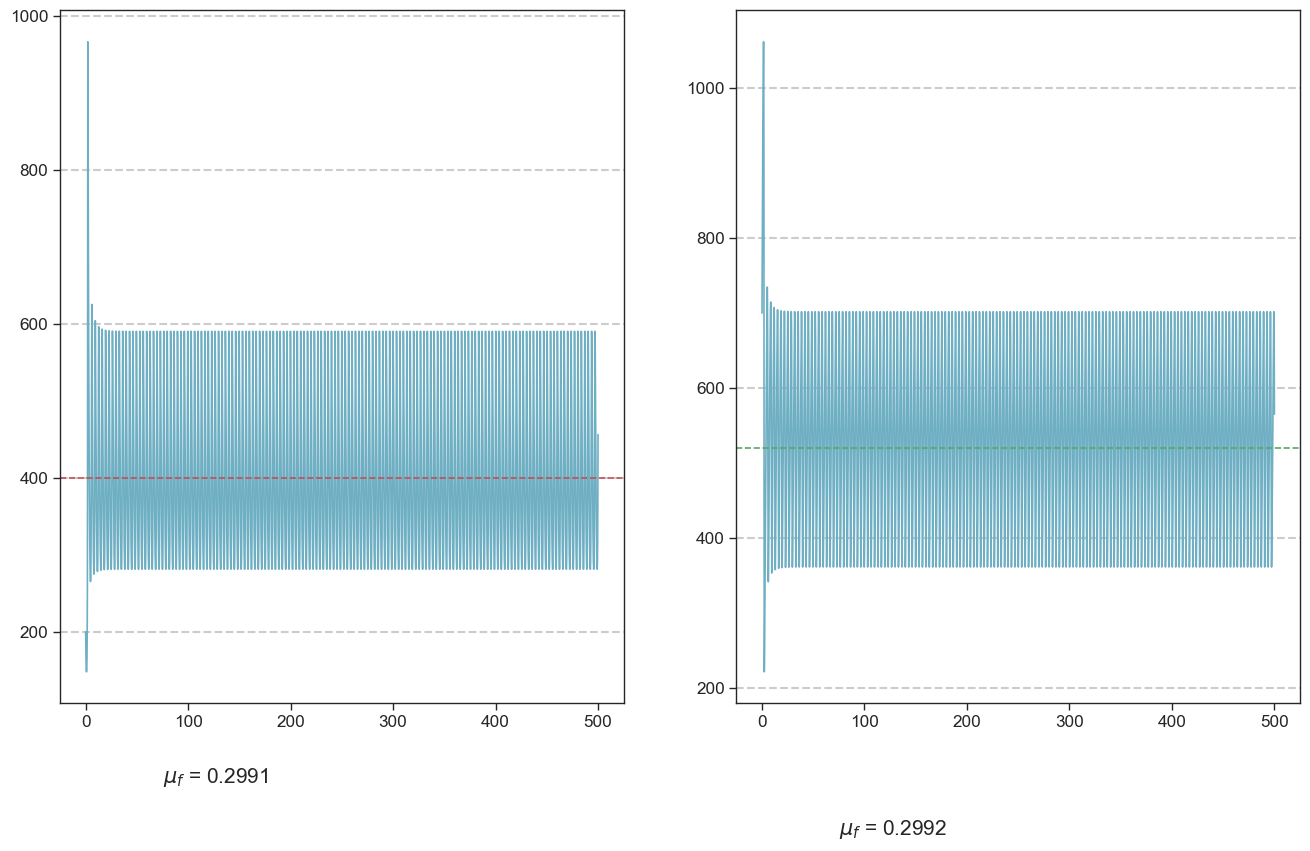

In [27]:

fig, ax = plt.subplots(1,2, figsize=(16,9), dpi=100)
ax[0].plot(t_list, x_list, label='x')
# ax[0].plot(tx_peaks, x_peaks, 'ro', label='peaks')
ax[0].axhline(x_star, color='r', linestyle='--', label='x*')
ax[0].text(75, 3.65, f'$\mu_f$ = {x_mean_freq:.4f}', fontsize=15);

ax[1].plot(t_list, y_list, label='y')
# ax[1].plot(ty_peaks, y_peaks, 'ro', label='peaks')
ax[1].axhline(y_star, color='g', linestyle='--', label='y*')

ax[1].text(75, 4.25, f'$\mu_f$ = {y_mean_freq:.4f}', fontsize=15);

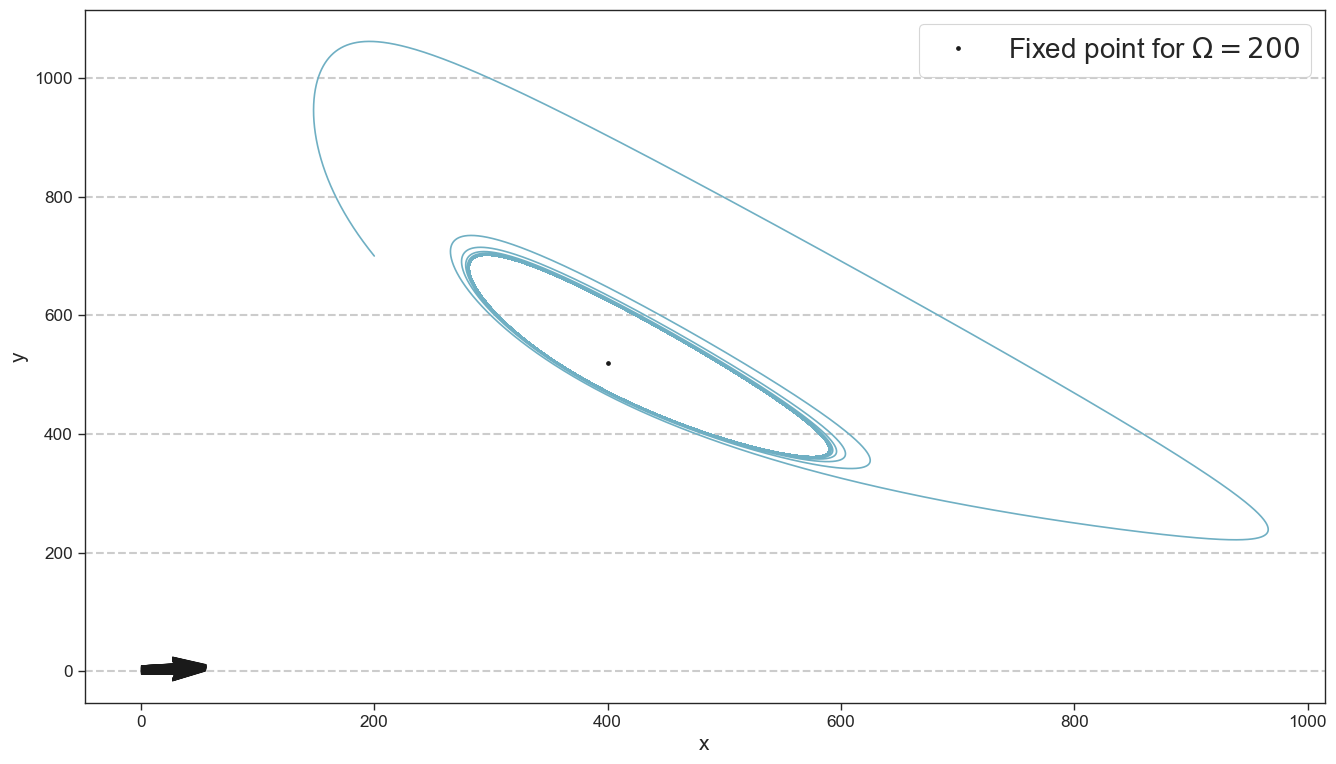

In [28]:
# 2D plot
fig = plt.figure(figsize=(16,9), dpi=100)
plt.plot(x_list, y_list)
plt.plot(x_star, y_star, 'k.', label=f'Fixed point for $\Omega = {V}$')
plt.xlabel('x', fontsize=15)
plt.ylabel('y', fontsize=15)
plt.legend(fontsize=20)


# Vector field
field_size = np.arange(0, 5.5, 0.5)
X, Y = np.meshgrid(field_size, field_size)
U = x_dot(X, Y, V)
P = y_dot(X, Y, V)


plt.quiver(X, Y, U, P);


/Users/nielsaugustdavidsen/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


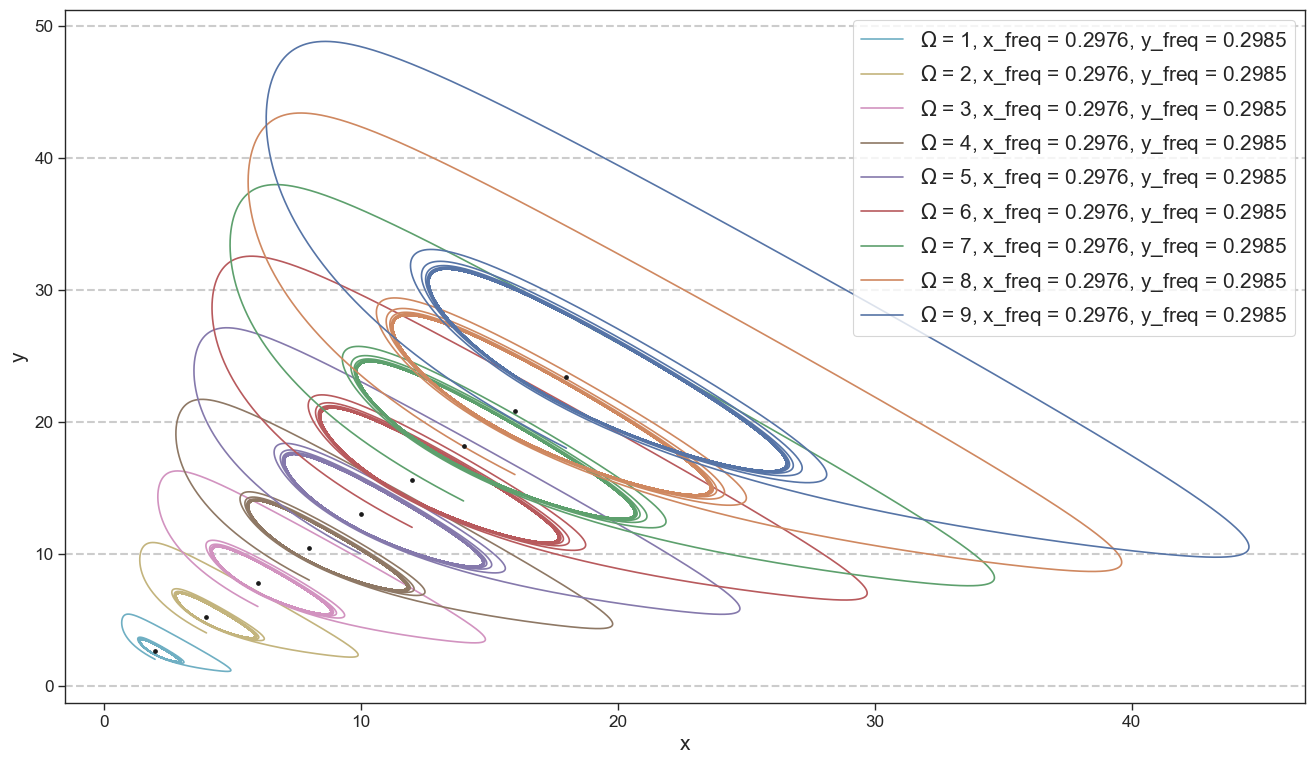

In [29]:
omega = np.arange(1, 10, 1)
var_change = np.array([2, 2])
x_mark_list = []
y_mark_list = []
x_freq_list = []
y_freq_list = []
dt_new = 0.001
t_max_new = 100

plt.figure(figsize=(16,9), dpi=100)
for i in omega:
    x_list_sim, y_list_sim, t_list_sim = euler(var_change, i, dt_new, t_max_new)
    x_mark_list.append(x_mark(i, a, d))
    y_mark_list.append(y_mark(i, a, b, c, d))
    x_freq = freq_find(x_list_sim, t_list_sim)
    y_freq = freq_find(y_list_sim, t_list_sim)
    plt.plot(x_list_sim, y_list_sim, label=f'$\Omega$ = {i}, x_freq = {x_freq:.4f}, y_freq = {y_freq:.4f}')
    plt.xlabel('x', fontsize=15)
    plt.ylabel('y', fontsize=15)
    plt.legend(fontsize=15)

plt.plot(x_mark_list, y_mark_list, 'k.', label='Stable fixed point')

____

# Adding oscillatory term $ A cos(\omega t)$

In [30]:

@numba.njit
def x_dot(x, y, t, a, b, c, d, V, omega, A):
    dxdt = a*V - (b + d) * x + c/(V**2) * x**2 * y + A * np.cos(omega * t)
    return dxdt

@numba.njit
def y_dot(x, y, V, b, c):
    dydt = b*x - c/(V**2) * x**2 * y
    return dydt

a = 2
b = 4.5
c = 1
d = 1
V = 100

@numba.njit
def euler(var_change, V, omega, A, dt, t_max):
    var = var_change*V
    x = var[0]
    y = var[1]
    t = 0
    x_list = []
    y_list = []
    t_list = []
    while t < t_max:
        x_list.append(x)
        y_list.append(y)
        t_list.append(t)
        x += dt * x_dot(x, y, t, a, b, c, d, V, omega, A)
        y += dt * y_dot(x, y, V, b, c)
        t += dt
    return x_list, y_list, t_list

@numba.njit
def amplitude_find(list1, list2, t_list, t_choise = 30):
    t_list = np.array(t_list)
    list1 = np.array(list1)
    list2 = np.array(list2)
    
    mask = np.where(t_list > t_choise)
    list1_mask = list1[mask[0]]
    list2_mask = list2[mask[0]]

    return np.max(list1_mask) - np.min(list1_mask), np.max(list2_mask) - np.min(list2_mask)



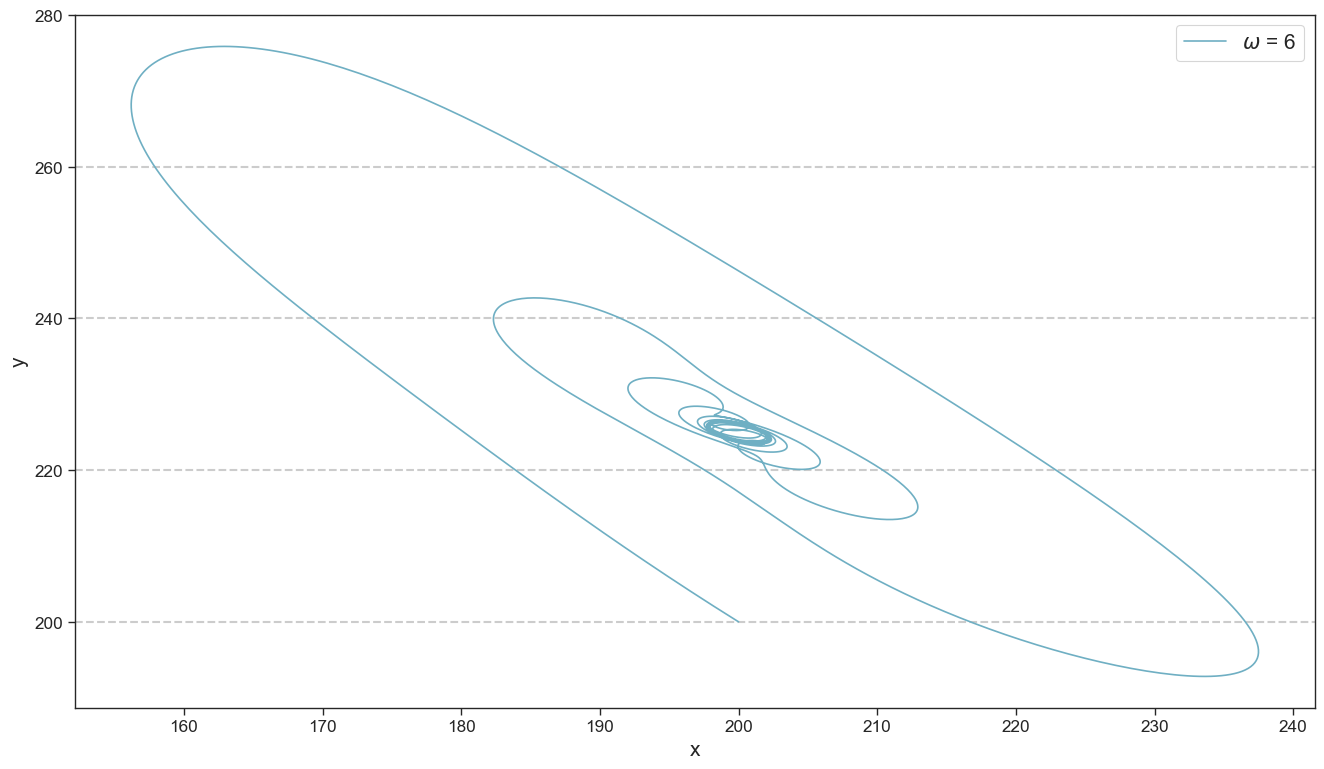

In [31]:
# run euler simulaiton with new x_dot and y_dot functions

omega = np.array([6])
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

fig, ax = plt.subplots(figsize=(16,9), dpi=100)

for i in omega:
    x_list, y_list, t_list = euler(var_change, V, i, A, dt, t_max)
    ax.plot(x_list, y_list, label=f'$\omega$ = {i}')

ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15)
ax.legend(fontsize=15)




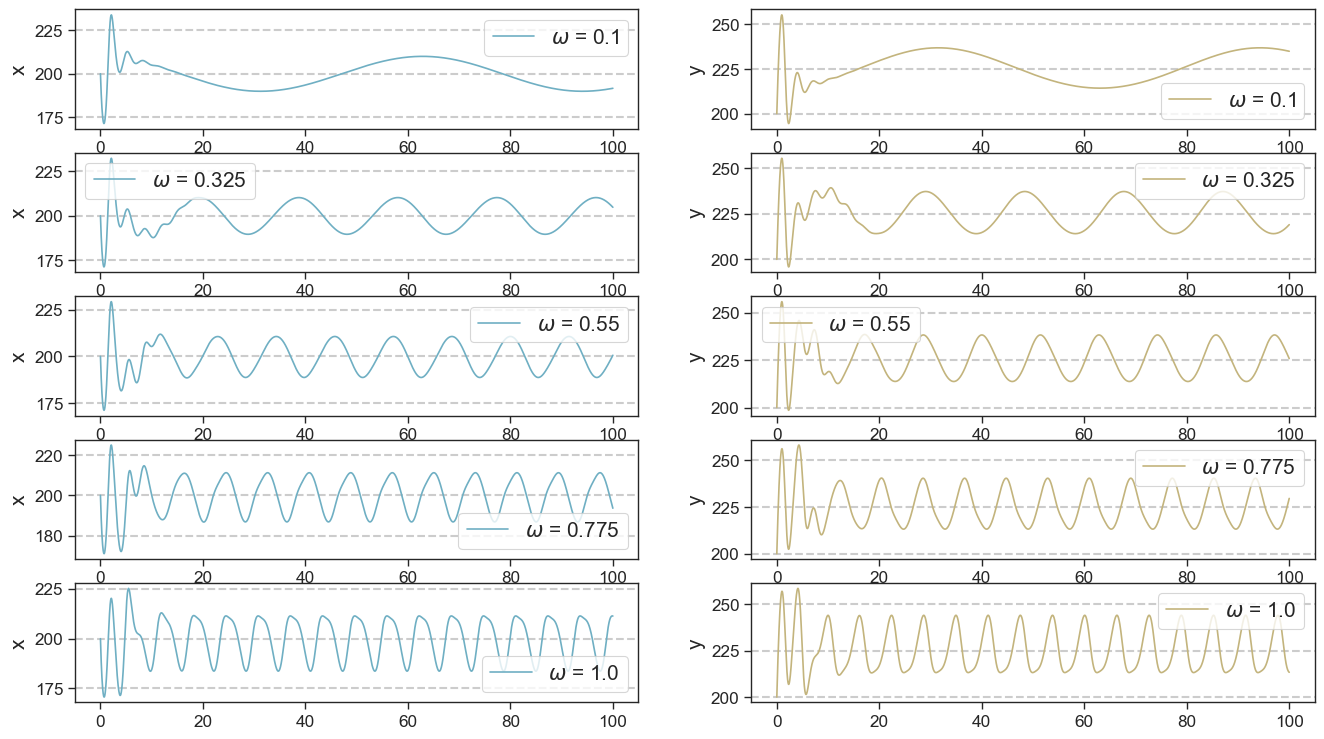

In [32]:
# plot x(t) and y(t) for different omega values

omega = np.linspace(0.1, 1, 5)
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

fig_rows = len(omega)
fig, ax = plt.subplots(fig_rows, 2, figsize=(16,9), dpi=100)


amp_x = []
amp_y = []

for i, j in enumerate(omega):
    x_list, y_list, t_list = euler(var_change, V, j, A, dt, t_max)
    

    ax[i, 0].plot(t_list, x_list, label=f'$\omega$ = {j}')
    ax[i, 1].plot(t_list, y_list, label=f'$\omega$ = {j}', color = colors[1])
    ax[i, 0].set_ylabel('x', fontsize=15)
    ax[i, 1].set_ylabel('y', fontsize=15)
    ax[i, 0].legend(fontsize=15)
    ax[i, 1].legend(fontsize=15)



### For a large number of $\omega$ 

In [33]:
omega_list = np.linspace(0.1, 5, 100)    
var_change = np.array([2, 2])
A = 10
t_max = 100
dt = 0.01

amp_x = []
amp_y = []

for i in omega_list:
    x_list, y_list, t_list = euler(var_change, V, i, A, dt, t_max)
    x_max, y_max = amplitude_find(x_list, y_list, t_list, t_choise=30)
    amp_x.append(x_max)
    amp_y.append(y_max)


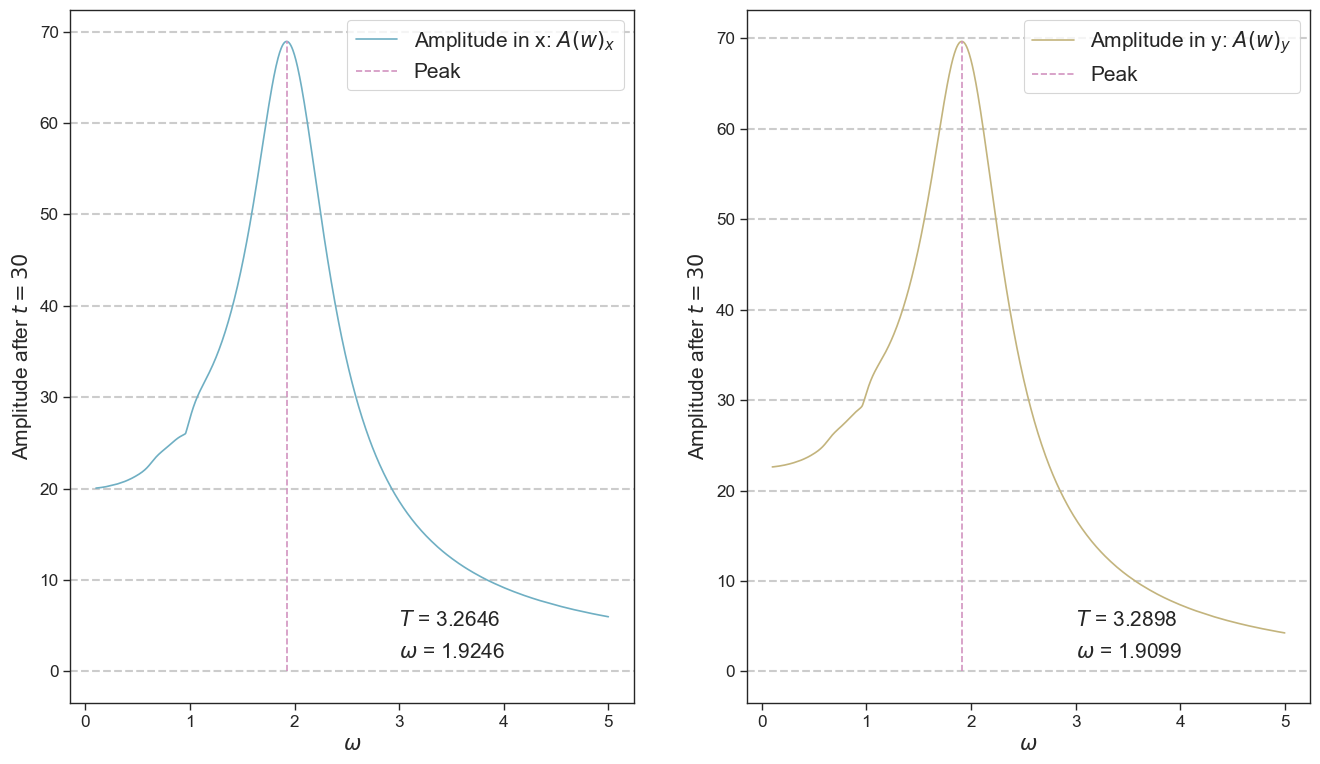

In [34]:
fig, ax = plt.subplots(1, 2, figsize=(16,9), dpi=100)
ax = ax.flatten()

# find peak

x_peak = np.max(amp_x)
y_peak = np.max(amp_y)
omega_x_peak = omega_list[np.argmax(amp_x)]
omega_y_peak = omega_list[np.argmax(amp_y)]
T_x = 2*np.pi/omega_x_peak
T_y = 2*np.pi/omega_y_peak

ax[0].plot(omega_list, amp_x, label=r'Amplitude in x: $A(w)_x$')
ax[0].set_xlabel('$\omega$', fontsize=15)
ax[0].set_ylabel('Amplitude after $t=30$', fontsize=15)
ax[0].vlines(omega_x_peak, 0, x_peak, color= colors[2], linestyle='--', label='Peak')
ax[0].text(3, 1.5, fr'$\omega$ = {omega_x_peak:.4f}', fontsize=15);
ax[0].text(3, 5, f'$T$ = {T_x:.4f}', fontsize=15);
ax[0].legend(fontsize=15)

ax[1].plot(omega_list, amp_y, label=r'Amplitude in y: $A(w)_y$', color = colors[1])
ax[1].set_xlabel('$\omega$', fontsize=15)
ax[1].vlines(omega_y_peak, 0, y_peak, color=colors[2], linestyle='--', label='Peak')
ax[1].set_ylabel('Amplitude after $t=30$', fontsize=15)
ax[1].text(3, 1.5, fr'$\omega$ = {omega_y_peak:.4f}', fontsize=15);
ax[1].text(3, 5, f'$T$ = {T_y:.4f}', fontsize=15);
ax[1].legend(fontsize=15)


____

# Gillespie algorithm

In [35]:
@numba.njit
def gillespie(x, y, t_max, b_place=b, V=100):

    t = 0
    click = 1
    t_list = [0]
    x_list = [x]
    y_list = [y]

    a = 2 * V
    c = 1/V**2
    d = 1
    
    
    while t < t_max:
        # rates
        x_spawn = a
        x_to_y = b_place * x
        y_to_x = c * x * (x-1) * y
        x_despawn = d * x
        
        rates = np.array([x_spawn, x_to_y, y_to_x, x_despawn])

        r_sum = np.cumsum(rates)
        R = np.sum(rates)
        u = np.random.uniform(0, R)
        dt = -np.log(np.random.uniform())/R


        mask = r_sum > u
        index = np.where(mask == True)[0][0]

        if index == 0:
            x += 1

        elif index == 1:
            x -= 1
            y += 1

        elif index == 2:
            y -= 1
            x += 1

        elif index == 3:
            x -= 1
        
        t += dt
        ts = 0.1
        if t > ts*click:
            t_list.append(t)
            x_list.append(x)
            y_list.append(y)
            click += 1

        #t_list.append(t)
        #x_list.append(x)
        #y_list.append(y)

    return t_list, x_list, y_list



In [36]:
# Gillespie simulation initialization
vol = 100
x = 100
y = 100
t_max = 500

# Setting parameters
a = 2
b = 5.2
c = 1
d = 1

# Running simulation
t_list, x_sim, y_sim = gillespie(x, y, t_max, b_place=b, V=vol)
x_star = x_mark(vol, a, d)
y_star = y_mark(vol, a, b, c, d)


[]


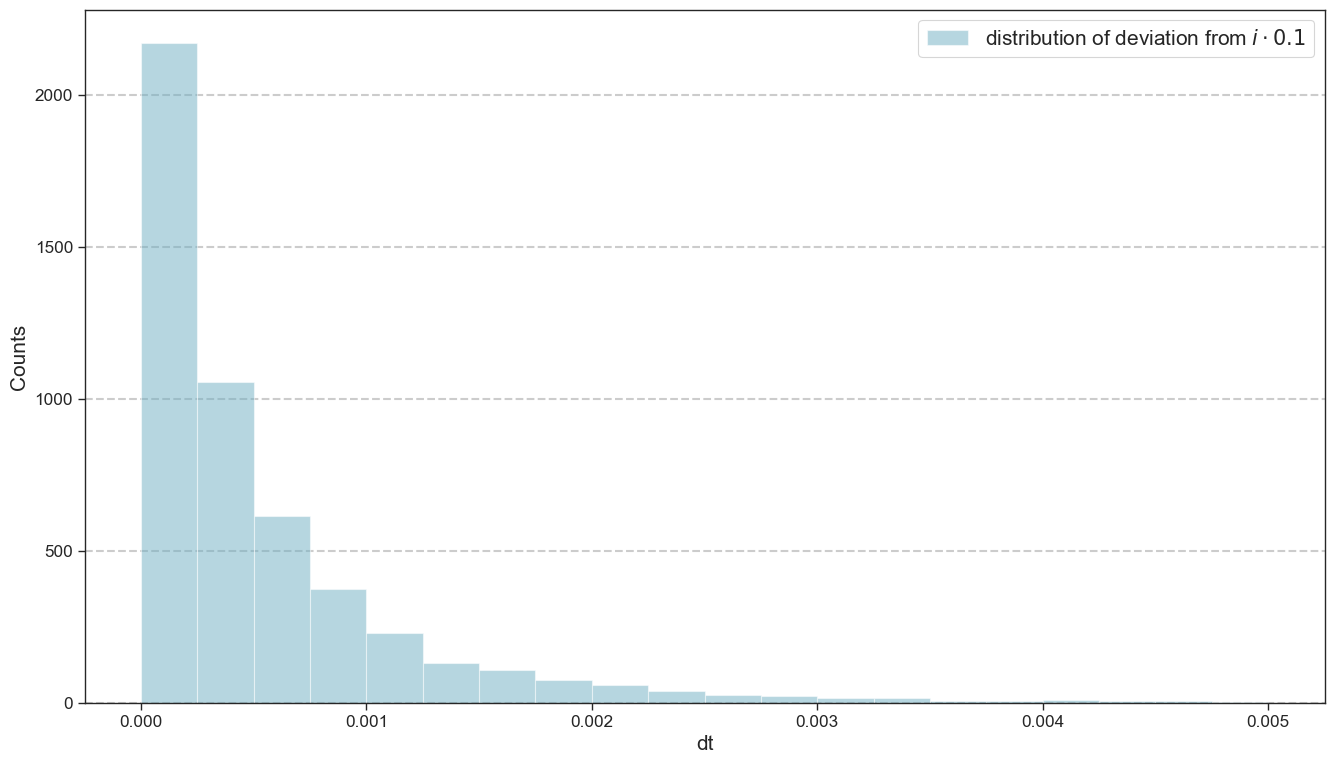

In [37]:
# Checking that the time steps are correct

n = np.arange(0, t_list[-1], 0.1)

dt_list = t_list - n
plt.hist(dt_list, bins=20, range=(0, 0.005), alpha=0.5, label=r'distribution of deviation from $i \cdot 0.1$');
plt.xlabel('dt', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.legend(fontsize=15)

over = np.where(dt_list > 0.1)
print(over[0])

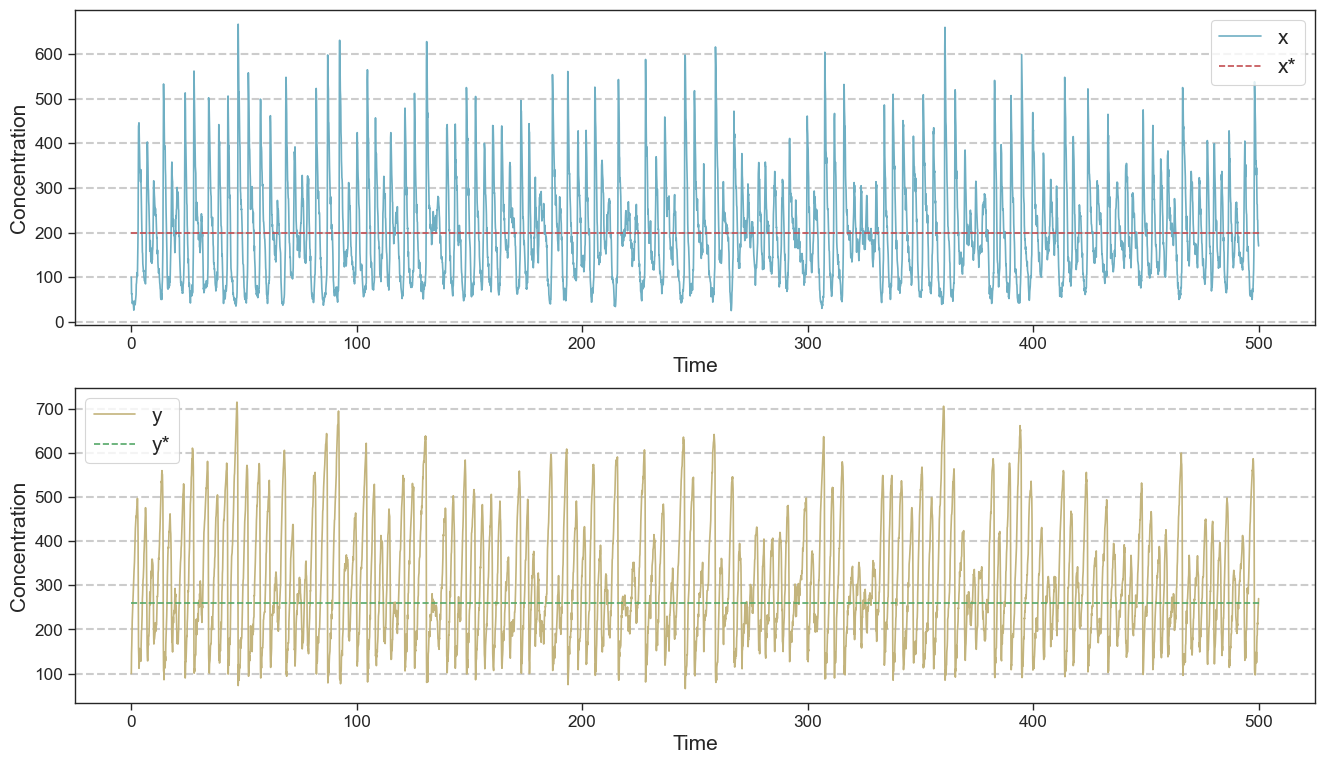

In [38]:
# Plotting gillespie simulation

fig, ax = plt.subplots(2, 1, figsize=(16,9), dpi=100)
ax[0].plot(t_list, x_sim, label='x', color=colors[0])
ax[0].hlines(x_star, 0, t_max, color='r', linestyle='--', label='x*')

ax[1].plot(t_list, y_sim, label='y', color=colors[1])
ax[1].hlines(y_star, 0, t_max, color='g', linestyle='--', label='y*')


for i in range(len(ax)):
    ax[i].set_xlabel('Time', fontsize=15)
    ax[i].set_ylabel('Concentration', fontsize=15)
    ax[i].legend(fontsize=15)



In [46]:

@numba.njit
def peak_find(t_list, y_list, neigh=10):
    t_peak = []
    peaks = []
    for i in range(len(y_list) - neigh):
        if y_list[i] > y_list[i-1] and y_list[i] > y_list[i+1]:


            # check N neighbours each way
            index_check = []
            for j in range(1, neigh+1):
                if y_list[i] > y_list[i-j] and y_list[i] > y_list[i+j]:
                    index_check.append(True)
                else:
                    index_check.append(False)

            if sum(index_check) == neigh:
                peaks.append(y_list[i])
                t_peak.append(t_list[i])

    return np.array(peaks), np.array(t_peak)


@numba.njit
def valley_find(t_list, y_list, neigh=10):
    t_valley = []
    valleys = []
    for i in range(len(y_list) - neigh):
        if y_list[i] < y_list[i-1] and y_list[i] < y_list[i+1]:


            # check N neighbours each way
            index_check = []
            for j in range(1, neigh+1):
                if y_list[i] < y_list[i-j] and y_list[i] < y_list[i+j]:
                    index_check.append(True)
                else:
                    index_check.append(False)

            if sum(index_check) == neigh:
                valleys.append(y_list[i])
                t_valley.append(t_list[i])

    return np.array(valleys), np.array(t_valley)


@numba.njit
def amp_match(t_peak, y_peak, t_valley, y_valley):
    amp = []
    for i in range(len(t_peak)):
        bigr = t_peak[i] > t_valley
        match = np.where(bigr == True)[0][0]
        amp.append((y_peak[i] - y_valley[match]))
    return amp


def easy_fourier(t_list, y_list):
    n = np.arange(0, t_list[-1], 0.1)
    t_list = t_list - n
    sr = np.mean(dt_list+0.1)

    y_fft = np.fft.fft(y_list)
    amplitude_spectrum = np.abs(y_fft)
    frequencies = np.fft.fftfreq(len(y_fft), sr)
    freq_slice = frequencies[1:len(frequencies)//2]
    amp_slice = amplitude_spectrum[1:len(amplitude_spectrum)//2]
    peak_freq = freq_slice[np.argmax(amp_slice)]
    return freq_slice, amp_slice, peak_freq


In [43]:
### High pass filter

# Define the cutoff frequency (in Hz)
cutoff_frequency = 0.04  # Cutoff frequency for high-pass filter
sampling_rate = np.mean(dt_list+0.1)

# Design the filter
nyquist = 0.5 * sampling_rate  # Nyquist frequency
normal_cutoff = cutoff_frequency / nyquist  # Normalize the cutoff frequency

b, a = signal.butter(4, normal_cutoff, btype='high', analog=False)  # 4th order Butterworth filter



No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
/Users/nielsaugustdavidsen/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/nielsaugustdavidsen/Library/Python/3.9/lib/python/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


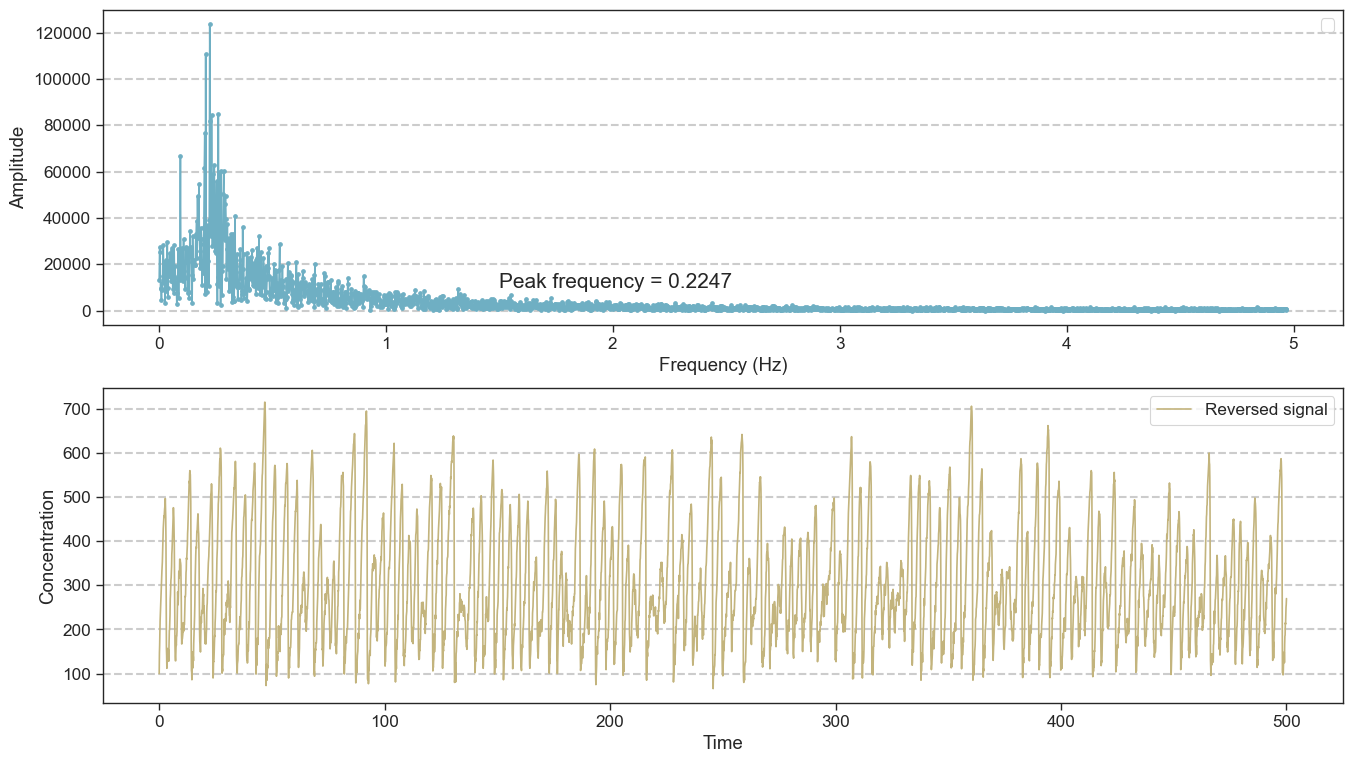

In [47]:
# Making a Fourier spectrum of x(t) and y(t) using FFT
x_fft = np.fft.fft(x_sim)
y_fft = np.fft.fft(y_sim)


##### Aply HP filter #####
x_hpf = x_fft #signal.filtfilt(b, a, x_fft)
y_hpf = y_fft #signal.filtfilt(b, a, y_fft)
##########################


freq_slice, amp_slice, peak_freq = easy_fourier(t_list, y_sim)


# Plot the amplitude spectrum

fig, ax = plt.subplots(2,1, dpi=100)
ax[0].plot(freq_slice, amp_slice, marker='.', ls='-')
ax[0].text(1.5, 10000, f'Peak frequency = {peak_freq:.4f}', fontsize=15)
ax[0].set_xlabel('Frequency (Hz)')
ax[0].set_ylabel('Amplitude')
ax[0].legend() 


y_reversed = np.fft.ifft(y_hpf)
# Plot reversed signal
ax[1].plot(t_list, y_reversed, label='Reversed signal', color=colors[1])
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Concentration')
ax[1].legend()

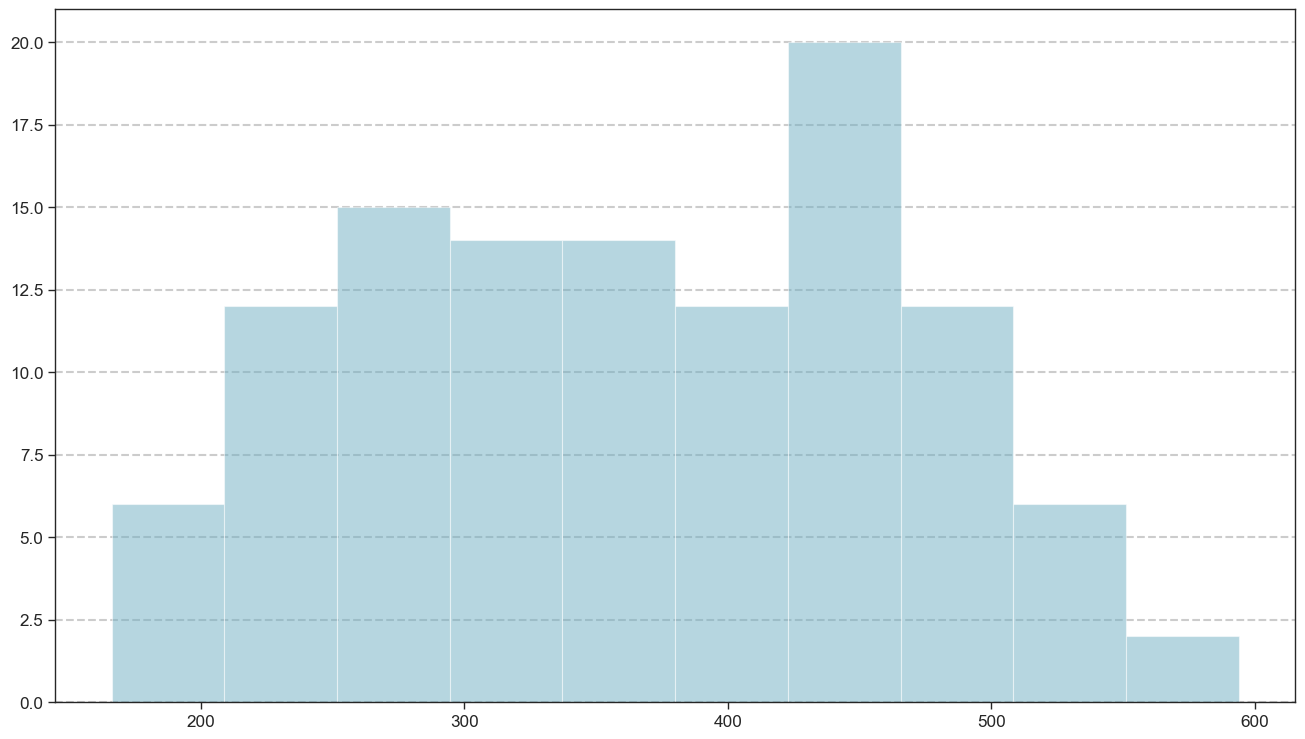

In [45]:
y_peaks, t_peaks = peak_find(t_list, y_sim, neigh=20)
y_valleys, t_valleys = valley_find(t_list, y_sim, neigh=20)

# Match peaks with valleys
amp = amp_match(t_peaks, y_peaks, t_valleys, y_valleys)


fig, ax = plt.subplots(1, 1, dpi=100)
#ax.plot(t_list, y_sim, label='y')
#ax.plot(t_peaks, y_peaks, 'ro', label='peaks')
#ax.plot(t_valleys, y_valleys, 'go', label='valleys')
ax.hist(amp, bins=10, alpha=0.5, label='Amplitude distribution');




In [52]:
# Defining Gillespie simulation function

def gil_sim(b, vol, t_max, x, y):
    t_sim, x_sim, y_sim = gillespie(x, y, t_max, b_place=b, V=vol)
    f_slice, a_slice, peak_f = easy_fourier(t_sim, y_sim)
    t_peak, y_peak = peak_find(t_sim, y_sim, neigh=20)
    t_valley, y_valley = valley_find(t_sim, y_sim, neigh=20)

    amps = amp_match(t_peak, y_peak, t_valley, y_valley)
    mean_amp = np.mean(amps)

    return peak_f, amps, mean_amp
    

In [57]:
# Initializing gillespie simulation
vol = 100
x = 100
y = 100
b_val = np.linspace(4.5, 5.5, 10)

# Running simulation
f_list, amp_list, mean_amp_list = [], [], []

for i in b_val:
    peak_f, amps, mean_amp = gil_sim(i, vol, t_max, x, y)
    f_list.append(peak_f)
    amp_list.append(amps)
    mean_amp_list.append(mean_amp)

print(mean_amp_list)

[253.3843004627409, 244.7339896957289, 250.7231845162556, 244.29812570921302, 246.30428273159436, 249.74891422166533, 258.262457251483, 250.95690800483902, 249.83476192390444, 242.8685082557799]
